In [372]:
import os
import pandas as pd 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint,  EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from sklearn.metrics import classification_report
from IPython.display import clear_output
from keras.regularizers import l2
from keras.optimizers import Adam
import contractions
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

import numpy as np




In [250]:
df_train = pd.read_csv(r"C:\Users\PC\Desktop\Toxic comments detection\train.csv\train.csv")
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Some exploration of Train data
Found the majority for non-Toxic comments

In [251]:
print(df_train.describe())
print(df_train.isnull().sum())  #check the missing values
print(df_train.iloc[:, 2:].sum()) 

               toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  
id               0
comment_text     

C:\Users\PC\AppData\Local\Temp\ipykernel_19900\2158968981.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette="viridis")
C:\Users\PC\AppData\Local\Temp\ipykernel_19900\2158968981.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(index, value, f'{toxicity_percentages[index]:.2f}%', ha='center', va='bottom')


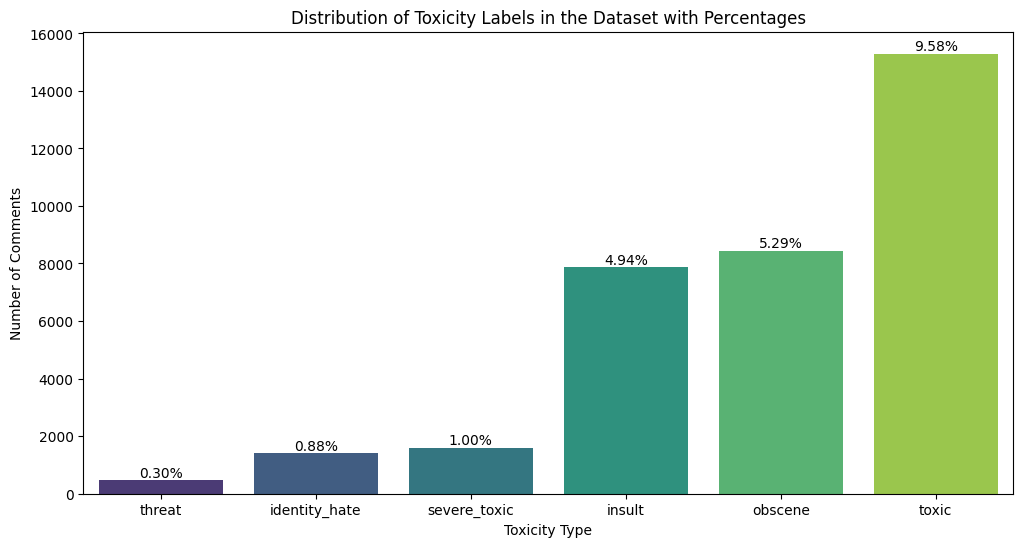

In [252]:
toxicity_counts = df_train.iloc[:, 2:].sum().sort_values()
toxicity_percentages = (toxicity_counts / len(df_train)) * 100

# Visualizing the distribution of toxicity labels with percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette="viridis")
plt.title('Distribution of Toxicity Labels in the Dataset with Percentages')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')

# Adding the percentage values on top of the bars
for index, value in enumerate(toxicity_counts.values):
    plt.text(index, value, f'{toxicity_percentages[index]:.2f}%', ha='center', va='bottom')

plt.show()

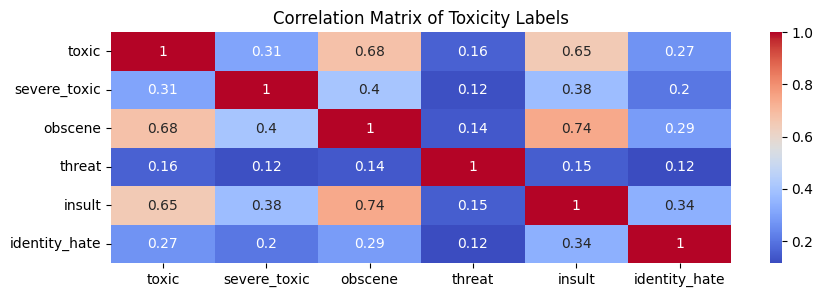

In [212]:
#Correlation matrix of the labels
plt.figure(figsize=(10, 3))
sns.heatmap(df_train.iloc[:, 2:].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()

Check the data Balance in Dataset 

C:\Users\PC\AppData\Local\Temp\ipykernel_19900\2778428363.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= balance_counts.index, y=balance_counts.values, palette="viridis")


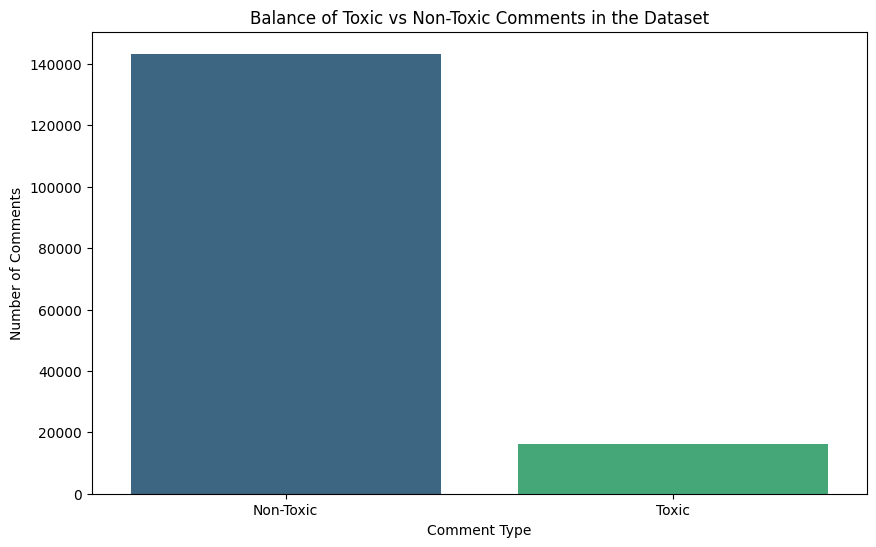

In [253]:
df_train['is_toxic'] = df_train.iloc[:, 2:].sum(axis=1) > 0
# Count the number of toxic vs non-toxic comments
balance_counts = df_train['is_toxic'].value_counts()

# Visualizing the balance between toxic and non-toxic comments
plt.figure(figsize=(10, 6))
sns.barplot(x= balance_counts.index, y=balance_counts.values, palette="viridis")
plt.title('Balance of Toxic vs Non-Toxic Comments in the Dataset')
plt.ylabel('Number of Comments')
plt.xlabel('Comment Type')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])  # Rename x-axis ticks for clarity
plt.show()

In [254]:
non_toxic_shape = df_train[df_train['is_toxic'] == False].shape
print(f"Shape of non-toxic comments: {non_toxic_shape}")

# Shape of toxic comments
toxic_shape = df_train[df_train['is_toxic'] == True].shape
print(f"Shape of toxic comments: {toxic_shape}")

Shape of non-toxic comments: (143346, 9)
Shape of toxic comments: (16225, 9)


In [215]:
non_toxic_downsampled = df_train[df_train['is_toxic'] == False].sample(n=toxic_shape[0], random_state=42)
toxic = df_train[df_train['is_toxic'] == True]

# Combine the downsampled non-toxic with toxic comments to create a balanced dataframe
balanced_df = pd.concat([non_toxic_downsampled, toxic])

# Check the shape of the balanced dataframe to confirm it's equal
balanced_shape = balanced_df.shape
print(f"Shape of the balanced dataframe: {balanced_shape}")


Shape of the balanced dataframe: (32450, 9)


In [255]:
balanced_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,word_count,char_count,preprocessed_text
46733,7ce2c22fd3409fbb,"""\n\nOh, don't worry about me, Sandstein. I'm ...",0,0,0,0,0,0,False,100,571,oh worry sandstein strong opinion well editing...
110326,4e366a5778e1b5b4,Are you trying to dispute that fact?,0,0,0,0,0,0,False,7,36,trying dispute fact
76687,cd62283cfe430f72,SWOT analysis \n\nThis source – Align Technolo...,0,0,0,0,0,0,False,53,291,swot analysis source align technology inc swot...
36231,60cdd48fb71157e6,"cover \n\nso, do we want a current or older co...",0,0,0,0,0,0,False,31,151,cover want current older cover paper edition s...
21514,38b04f0b55ac0c31,P.S. It's probably worth setting up a template...,0,0,0,0,0,0,False,51,251,p probably worth setting template used period ...


Analysis on Balance Data Now

C:\Users\PC\AppData\Local\Temp\ipykernel_19900\2251474064.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette="viridis")


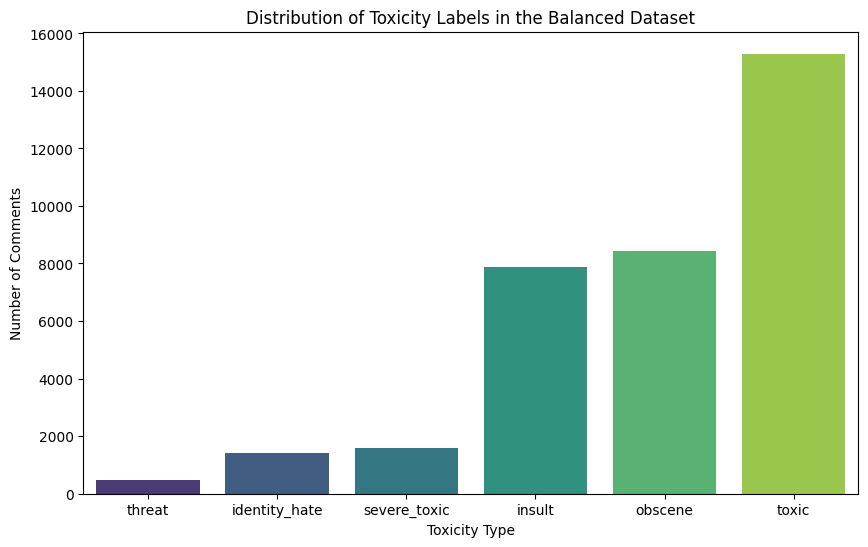

In [256]:
toxicity_counts = balanced_df.iloc[:, 2:8].sum().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette="viridis")
plt.title('Distribution of Toxicity Labels in the Balanced Dataset')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.show()

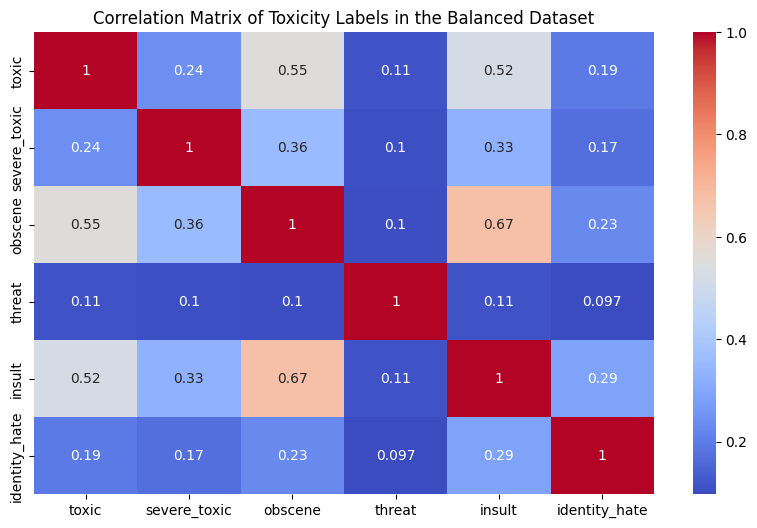

In [257]:
plt.figure(figsize=(10, 6))
sns.heatmap(balanced_df.iloc[:, 2:8].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Toxicity Labels in the Balanced Dataset')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_19900\3175215701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df['word_count'] = balanced_df['comment_text'].apply(lambda x: len(x.split()))
C:\Users\PC\AppData\Local\Temp\ipykernel_19900\3175215701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df['char_count'] = balanced_df['comment_text'].apply(lambda x: len(x))


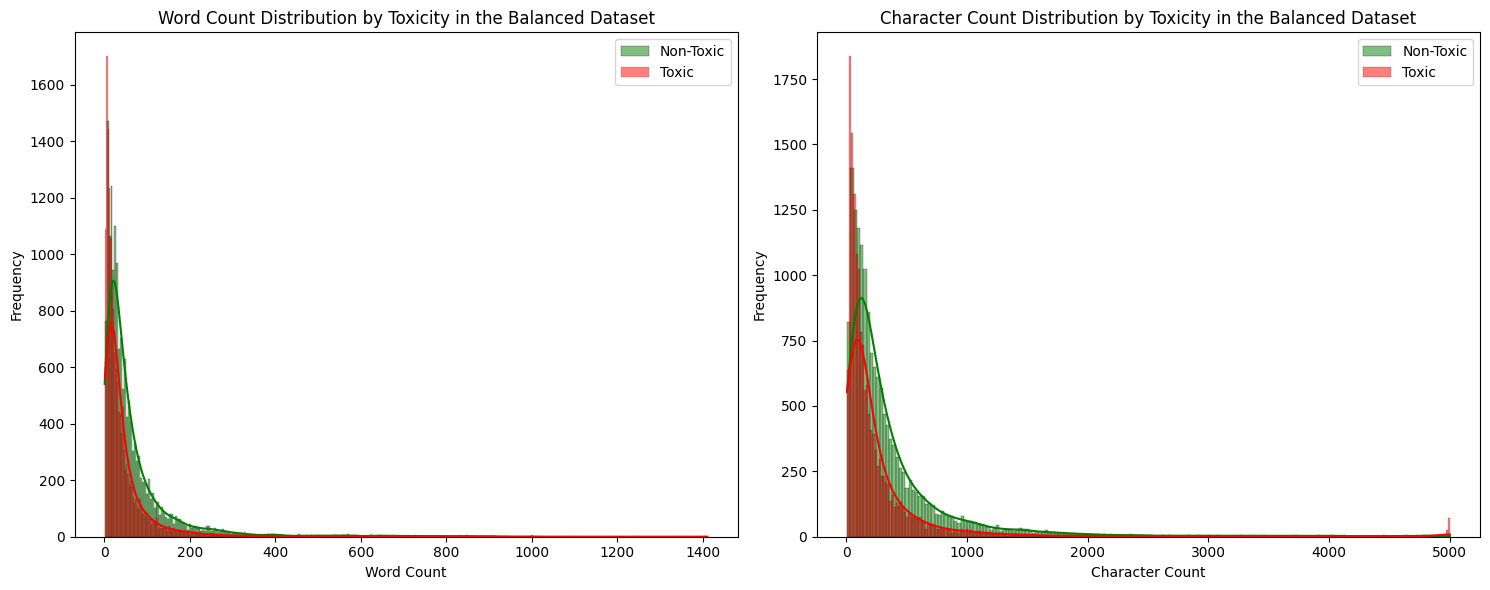

In [258]:
# Assuming balanced_df is your balanced dataset
balanced_df['word_count'] = balanced_df['comment_text'].apply(lambda x: len(x.split()))
balanced_df['char_count'] = balanced_df['comment_text'].apply(lambda x: len(x))

# Histograms for word and character count
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(balanced_df[balanced_df['is_toxic'] == 0]['word_count'], color='green', label='Non-Toxic', kde=True)
sns.histplot(balanced_df[balanced_df['is_toxic'] == 1]['word_count'], color='red', label='Toxic', kde=True)
plt.title('Word Count Distribution by Toxicity in the Balanced Dataset')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(balanced_df[balanced_df['is_toxic'] == 0]['char_count'], color='green', label='Non-Toxic', kde=True)
sns.histplot(balanced_df[balanced_df['is_toxic'] == 1]['char_count'], color='red', label='Toxic', kde=True)
plt.title('Character Count Distribution by Toxicity in the Balanced Dataset')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


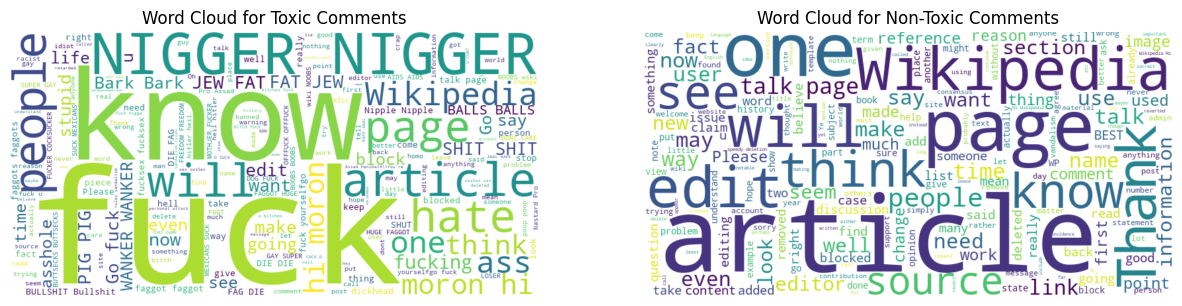

In [259]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all comments into one large text
toxic_text = ' '.join(balanced_df[balanced_df['is_toxic']]['comment_text'])
nontoxic_text = ' '.join(balanced_df[~balanced_df['is_toxic']]['comment_text'])

# Generate word clouds
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_text)
wordcloud_nontoxic = WordCloud(width=800, height=400, background_color='white').generate(nontoxic_text)

# Display the word clouds
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.title('Word Cloud for Toxic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_nontoxic, interpolation='bilinear')
plt.title('Word Cloud for Non-Toxic Comments')
plt.axis('off')

plt.show()


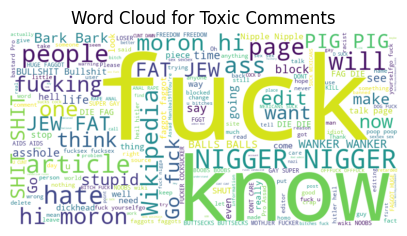

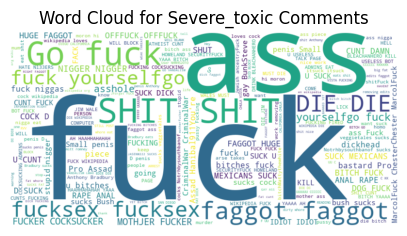

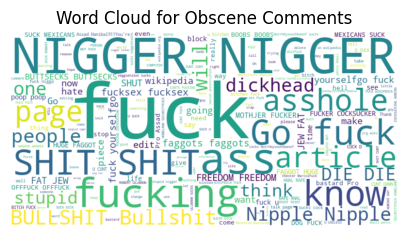

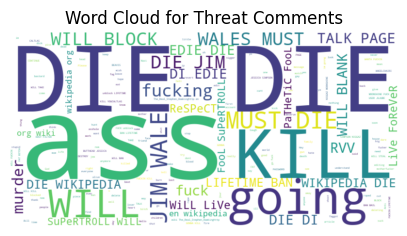

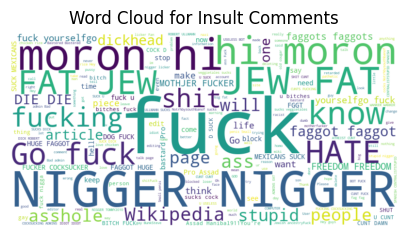

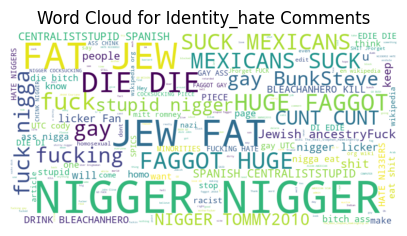

In [260]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(5, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate a word cloud for each toxicity label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in labels:
    # Combine all comments for the label into one text
    text = ' '.join(balanced_df[balanced_df[label] == 1]['comment_text'])
    generate_wordcloud(text, f'Word Cloud for {label.capitalize()} Comments')


C:\Users\PC\AppData\Local\Temp\ipykernel_19900\3415869962.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


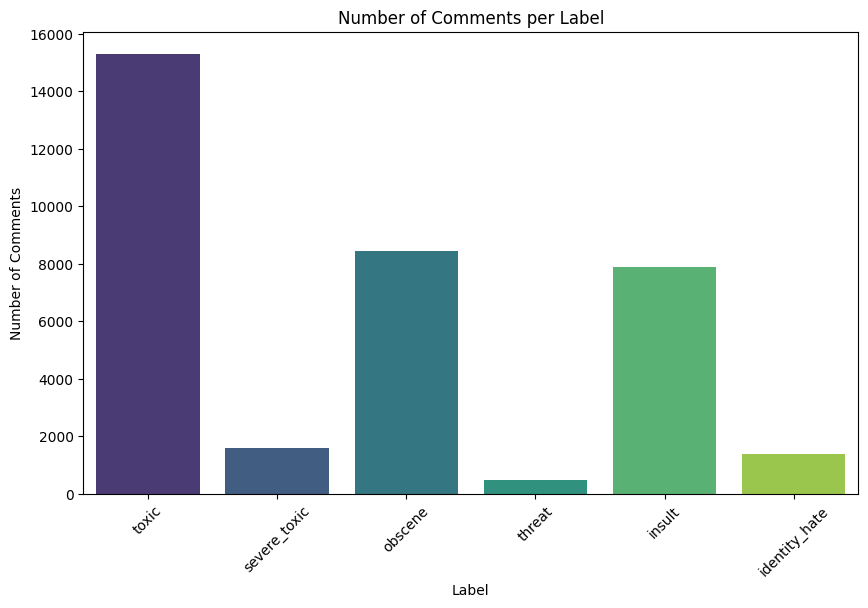

In [261]:
label_counts = df_train.iloc[:, 2:8].sum()

# Visualize the distribution of comments per label
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Number of Comments per Label')
plt.ylabel('Number of Comments')
plt.xlabel('Label')
plt.xticks(rotation=45)
plt.show()

Data preprocessing


In [29]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...


True

In [262]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    # Expand contractions
    text = contractions.fix(text)
    
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])
    return lemmatized_text


In [271]:
#Clean the train data
balanced_df['preprocessed_text'] = balanced_df['comment_text'].apply(preprocess_text)

# Filter out any entries that have become empty after preprocessing
balanced_df = balanced_df[balanced_df['preprocessed_text'].str.strip().str.len() > 0]

# Confirm that the dataset still has data left after preprocessing
print(f"Remaining dataset size: {balanced_df.shape}")


Remaining dataset size: (32445, 12)


Feature Engineering 

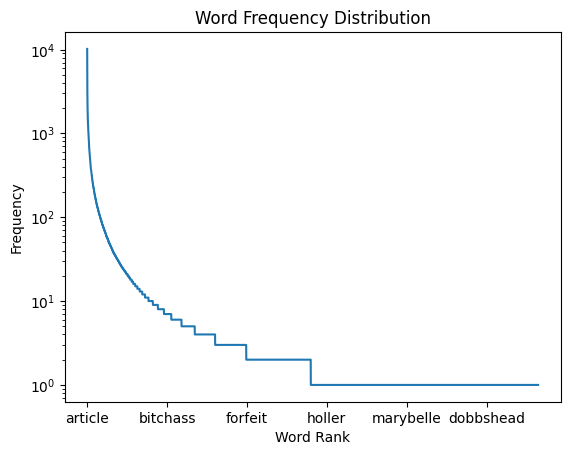

In [529]:
# Analyze the lengths of preprocessed comments
lengths = balanced_df['preprocessed_text'].str.split().apply(len)
max_sequence_length = int(lengths.quantile(0.95))



all_words = [word for text in balanced_df['preprocessed_text'] for word in text.split()]
word_freq = pd.Series(all_words).value_counts()

# Plot the frequency distribution to help decide on a cutoff
word_freq.plot(logy=True, title='Word Frequency Distribution', xlabel='Word Rank', ylabel='Frequency')


max_vocab_size = word_freq[word_freq >= 5].size

In [530]:
# Create the TextVectorization layer with the determined sizes

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length
)

# Adapt the vectorization layer to your text data
vectorize_layer.adapt(balanced_df['preprocessed_text'].to_numpy())



In [492]:
# Split the dataset into features and labels
X = balanced_df['preprocessed_text'].to_numpy()
y = balanced_df['is_toxic'].values  # Replace 'is_toxic' with your actual labels column name

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [493]:
# Vectorize the text in the datasets
train_dataset = train_dataset.map(lambda x, y: (vectorize_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (vectorize_layer(x), y)).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (vectorize_layer(x), y)).prefetch(tf.data.AUTOTUNE)

Build My Model 

In [276]:
class LivePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}  # Store training and validation metrics
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric not in self.metrics:
                self.metrics[metric] = []
            self.metrics[metric].append(logs[metric])

        # Clear the previous plot
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))

        # Plot each metric
        for i, (metric, values) in enumerate(self.metrics.items()):
            plt.subplot(1, len(self.metrics), i+1)
            plt.plot(range(1, epoch + 2), values, label=metric)
            plt.title(f'{metric.upper()} over Epochs')
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()

        plt.tight_layout()
        plt.show()

Building a Model 

In [277]:
model = Sequential([
    Embedding(max_vocab_size + 1, 32),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 32)          430848    
                                                                 
 bidirectional_13 (Bidirect  (None, 128)               49664     
 ional)                                                          
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dropout_58 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                     

In [278]:
checkpoint_dir = './BinaryModel1'
os.makedirs(checkpoint_dir, exist_ok=True)

# It saves the best model based on validation accuracy
checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model.ckpt')

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    LivePlot()  
]

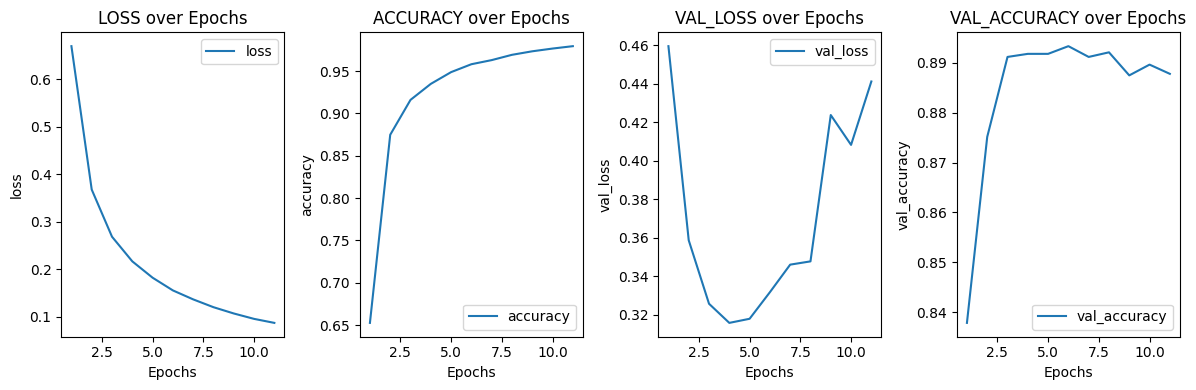

812/812 [==============================] - 28s 35ms/step - loss: 0.0871 - accuracy: 0.9793 - val_loss: 0.4412 - val_accuracy: 0.8878
Epoch 11: early stopping


In [279]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  
    callbacks=callbacks
)

model.load_weights(checkpoint_filepath)


In [280]:
model.save('BinaryModel1')


INFO:tensorflow:Assets written to: BinaryModel1\assets


INFO:tensorflow:Assets written to: BinaryModel1\assets


Evaluation 

In [281]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

102/102 [==============================] - 1s 13ms/step - loss: 0.3253 - accuracy: 0.8983
Test Loss: 0.3252880871295929, Test Accuracy: 0.8983050584793091


In [283]:
model = load_model('BinaryModel1')


performance Matrix 

In [284]:
# Predict labels for the test set
y_pred_probs = model.predict(test_dataset)
y_pred = np.round(y_pred_probs).astype(int)  

# Calculate additional performance metrics
print(classification_report(y_test, y_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


102/102 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

       False       0.89      0.90      0.90      1622
        True       0.90      0.89      0.90      1623

    accuracy                           0.90      3245
   macro avg       0.90      0.90      0.90      3245
weighted avg       0.90      0.90      0.90      3245

Confusion Matrix:
 [[1464  158]
 [ 172 1451]]


predictions

In [298]:
def predict_toxicity(model, vectorize_layer, input_text):
    # Preprocess the text
    preprocessed_text = preprocess_text(input_text)  # Using the preprocess_text function defined earlier
    
    # Vectorize the preprocessed text
    vectorized_input_text = vectorize_layer(tf.convert_to_tensor([preprocessed_text]))  # Convert to tensor and add batch dimension
    
    # Get the prediction
    prediction = model.predict(vectorized_input_text)
    
    # Since you're expecting a single prediction, extract the first element
    toxic_prob = prediction[0][0]
    
    is_toxic = toxic_prob > 0.5
    
    return toxic_prob, is_toxic

# Test the function with sample text
text = "You are good person"
prob, toxic_status = predict_toxicity(model, vectorize_layer, text)

print(f"Probability of being toxic: {prob:.4f}")
print("Toxic" if toxic_status else "Not toxic")


1/1 [==============================] - 0s 35ms/step
Probability of being toxic: 0.1720
Not toxic


Multi-Label Classification 


In [531]:
X = balanced_df['preprocessed_text']
y = balanced_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values  # For multi-label classification


In [504]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (32445,)
Shape of y: (32445, 6)


In [532]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train.astype('float32'))).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val.astype('float32'))).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test.astype('float32'))).batch(32).prefetch(tf.data.AUTOTUNE)

In [506]:
# Ensure no missing values
assert balanced_df.isnull().sum().sum() == 0, "There are missing values in the dataset!"

# Check if any preprocessed text is empty after preprocessing
assert balanced_df['preprocessed_text'].apply(lambda x: len(x.strip())).min() > 0, "Some preprocessed texts are empty!"

# Print out the class distribution
class_distribution = balanced_df.iloc[:, 2:8].sum()
print("Class distribution after balancing:\n", class_distribution)


Class distribution after balancing:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [507]:
def calculate_class_weights(class_counts):
    total_counts = sum(class_counts)
    return {i: total_counts/count for i, count in enumerate(class_counts)}

class_counts = [15294, 1595, 8449, 478, 7877, 1405]  
class_weights = calculate_class_weights(class_counts)


def weighted_binary_crossentropy(y_true, y_pred):
    class_weights_tensor = tf.constant([class_weights[i] for i in range(6)], dtype=tf.float32)
    class_weights_tensor = tf.expand_dims(class_weights_tensor, 0)
    class_weights_tensor = tf.tile(class_weights_tensor, [tf.shape(y_true)[0], 1])
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * class_weights_tensor
    return tf.reduce_mean(weighted_bce, axis=-1)

In [508]:
from tensorflow.keras.metrics import Precision, Recall

multiclass = Sequential([
    vectorize_layer,
    Embedding(max_vocab_size + 1, 32, input_length=max_sequence_length),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(16)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='sigmoid')  
])

multiclass.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=weighted_binary_crossentropy,
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


multiclass.summary()



Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Tex  (None, 106)               0         
 tVectorization)                                                 
                                                                 
 embedding_42 (Embedding)    (None, 106, 32)           3200032   
                                                                 
 dropout_117 (Dropout)       (None, 106, 32)           0         
                                                                 
 bidirectional_46 (Bidirect  (None, 106, 64)           16640     
 ional)                                                          
                                                                 
 dropout_118 (Dropout)       (None, 106, 64)           0         
                                                                 
 bidirectional_47 (Bidirect  (None, 32)              

In [509]:
checkpoint_dir = './multiclass_model'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint file path pattern


checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model.ckpt')



early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_filepath , monitor='val_loss', save_best_only=True, verbose=1)



In [334]:
history = multiclass.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

multiclass.load_weights(checkpoint_filepath)


Epoch 1/20


811/812 [============================>.] - ETA: 0s - loss: 3.9112 - accuracy: 0.9106 - precision: 0.4775 - recall: 0.1817
Epoch 1: val_loss improved from inf to 2.74398, saving model to ./multiclass_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


812/812 [==============================] - 48s 53ms/step - loss: 3.9107 - accuracy: 0.9106 - precision: 0.4775 - recall: 0.1817 - val_loss: 2.7440 - val_accuracy: 0.9713 - val_precision: 0.9219 - val_recall: 0.1930
Epoch 2/20
811/812 [============================>.] - ETA: 0s - loss: 2.4838 - accuracy: 0.9667 - precision: 0.7724 - recall: 0.5615
Epoch 2: val_loss improved from 2.74398 to 2.52449, saving model to ./multiclass_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


812/812 [==============================] - 41s 51ms/step - loss: 2.4835 - accuracy: 0.9668 - precision: 0.7724 - recall: 0.5615 - val_loss: 2.5245 - val_accuracy: 0.9716 - val_precision: 0.8128 - val_recall: 0.4882
Epoch 3/20
811/812 [============================>.] - ETA: 0s - loss: 2.2344 - accuracy: 0.9710 - precision: 0.7793 - recall: 0.6368
Epoch 3: val_loss improved from 2.52449 to 2.50258, saving model to ./multiclass_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


812/812 [==============================] - 42s 52ms/step - loss: 2.2342 - accuracy: 0.9710 - precision: 0.7793 - recall: 0.6368 - val_loss: 2.5026 - val_accuracy: 0.9716 - val_precision: 0.7905 - val_recall: 0.5618
Epoch 4/20
811/812 [============================>.] - ETA: 0s - loss: 2.0433 - accuracy: 0.9715 - precision: 0.7823 - recall: 0.6700
Epoch 4: val_loss improved from 2.50258 to 2.49134, saving model to ./multiclass_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


812/812 [==============================] - 44s 55ms/step - loss: 2.0430 - accuracy: 0.9715 - precision: 0.7823 - recall: 0.6700 - val_loss: 2.4913 - val_accuracy: 0.9716 - val_precision: 0.8041 - val_recall: 0.5655
Epoch 5/20
811/812 [============================>.] - ETA: 0s - loss: 1.8168 - accuracy: 0.9716 - precision: 0.7988 - recall: 0.6939
Epoch 5: val_loss improved from 2.49134 to 2.42785, saving model to ./multiclass_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./multiclass_model\best_model.ckpt\assets


812/812 [==============================] - 43s 53ms/step - loss: 1.8165 - accuracy: 0.9716 - precision: 0.7988 - recall: 0.6939 - val_loss: 2.4279 - val_accuracy: 0.9716 - val_precision: 0.7747 - val_recall: 0.6677
Epoch 6/20
811/812 [============================>.] - ETA: 0s - loss: 1.6957 - accuracy: 0.9716 - precision: 0.8044 - recall: 0.7164
Epoch 6: val_loss did not improve from 2.42785
812/812 [==============================] - 31s 39ms/step - loss: 1.6954 - accuracy: 0.9716 - precision: 0.8044 - recall: 0.7164 - val_loss: 2.5538 - val_accuracy: 0.9716 - val_precision: 0.7884 - val_recall: 0.6528
Epoch 7/20
811/812 [============================>.] - ETA: 0s - loss: 1.5670 - accuracy: 0.9716 - precision: 0.8088 - recall: 0.7334
Epoch 7: val_loss did not improve from 2.42785
812/812 [==============================] - 32s 39ms/step - loss: 1.5668 - accuracy: 0.9716 - precision: 0.8088 - recall: 0.7334 - val_loss: 2.6724 - val_accuracy: 0.9716 - val_precision: 0.7836 - val_recall: 0.

In [335]:
multiclass.save('multiclass_model')


INFO:tensorflow:Assets written to: multiclass_model\assets


INFO:tensorflow:Assets written to: multiclass_model\assets


In [510]:
multiclass = load_model('multiclass_model', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})


In [511]:
test_loss, test_accuracy, test_precision, test_recall = multiclass.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}")

102/102 [==============================] - 4s 17ms/step - loss: 2.1398 - accuracy: 0.9683 - precision: 0.8109 - recall: 0.6810
Test Loss: 2.1397955417633057, Test Accuracy: 0.9682588577270508, Precision: 0.8108739256858826, Recall: 0.6809523701667786


In [512]:
def flatten_test_labels(test_dataset):
    y_test_flattened = []
    for _, y in test_dataset.unbatch():
        y_test_flattened.append(y.numpy())
    return np.vstack(y_test_flattened)


In [513]:
from sklearn.metrics import classification_report

# Flatten the test labels
y_test_flattened = flatten_test_labels(test_dataset)

# Predict on the test set
y_pred = multiclass.predict(test_dataset)
y_pred_binary = (y_pred > 0.5).astype(int)

# Trim y_pred_binary if necessary
if y_pred_binary.shape[0] > y_test_flattened.shape[0]:
    y_pred_binary = y_pred_binary[:y_test_flattened.shape[0], :]

# Calculate class-specific performance
report = classification_report(y_test_flattened, y_pred_binary, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
print(report)



102/102 [==============================] - 4s 17ms/step
               precision    recall  f1-score   support

        toxic       0.89      0.79      0.84      1517
 severe_toxic       0.51      0.32      0.40       154
      obscene       0.80      0.73      0.77       875
       threat       0.54      0.42      0.47        50
       insult       0.72      0.64      0.68       820
identity_hate       0.00      0.00      0.00       154

    micro avg       0.81      0.68      0.74      3570
    macro avg       0.58      0.48      0.53      3570
 weighted avg       0.77      0.68      0.72      3570
  samples avg       0.33      0.31      0.30      3570



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

In [566]:
new_text = "Such an Idiot person"  # Single text string
predictions = multiclass.predict([new_text]) > 0.5

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Format and print the prediction results
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<20}: {predicted_labels[0][i]}\n"

print(prediction_text)

1/1 [==============================] - 0s 80ms/step
toxic               : 1
severe_toxic        : 0
obscene             : 1
threat              : 0
insult              : 1
identity_hate       : 0



Enhanced model

In [533]:
# Split the dataset into training, validation, and test sets for multilabel classification
X_train, X_temp, y_train, y_temp = train_test_split(balanced_df['preprocessed_text'], balanced_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train.astype('float32'))).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val.astype('float32'))).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test.astype('float32'))).batch(32).prefetch(tf.data.AUTOTUNE)

In [552]:
class_weights_dict = {}
for i in range(y_train.shape[1]):
    weights = compute_class_weight('balanced', classes=np.unique(y_train[:, i]), y=y_train[:, i])
    class_weights_dict[i] = {0: weights[0], 1: weights[1]}

# Define the custom weighted loss function
def get_weighted_loss(class_weights):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        for i in range(len(class_weights)):
            y_true_slice = y_true[..., i]
            y_pred_slice = y_pred[..., i]
            bce = tf.keras.losses.binary_crossentropy(y_true_slice, y_pred_slice)
            weight_vector = y_true_slice * class_weights[i][1] + (1 - y_true_slice) * class_weights[i][0]
            weighted_bce = weight_vector * bce
            loss += tf.reduce_mean(weighted_bce) / len(class_weights)
        return loss
    return weighted_loss




In [555]:
enhance_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=32, mask_zero=True),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

# Compile the model
enhance_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=get_weighted_loss(class_weights_dict),
    metrics=['accuracy', Precision(), Recall()]
)


In [556]:
checkpoint_dir = './enhance_model'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint file path pattern
checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model.ckpt')



early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True, verbose=1)


In [557]:
history = enhance_model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping, model_checkpoint]
)

enhance_model.load_weights(checkpoint_filepath)



Epoch 1/20
812/812 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.7574 - precision_12: 0.4254 - recall_12: 0.2757
Epoch 1: val_loss improved from inf to 0.35630, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 138s 146ms/step - loss: 0.4827 - accuracy: 0.7574 - precision_12: 0.4254 - recall_12: 0.2757 - val_loss: 0.3563 - val_accuracy: 0.9710 - val_precision_12: 0.7760 - val_recall_12: 0.2307
Epoch 2/20
812/812 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8001 - precision_12: 0.7106 - recall_12: 0.5051
Epoch 2: val_loss improved from 0.35630 to 0.26034, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 79s 97ms/step - loss: 0.3262 - accuracy: 0.8001 - precision_12: 0.7106 - recall_12: 0.5051 - val_loss: 0.2603 - val_accuracy: 0.9716 - val_precision_12: 0.7933 - val_recall_12: 0.6231
Epoch 3/20
812/812 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8568 - precision_12: 0.7654 - recall_12: 0.6668
Epoch 3: val_loss improved from 0.26034 to 0.23728, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 82s 101ms/step - loss: 0.2653 - accuracy: 0.8568 - precision_12: 0.7654 - recall_12: 0.6668 - val_loss: 0.2373 - val_accuracy: 0.9716 - val_precision_12: 0.8137 - val_recall_12: 0.6540
Epoch 4/20
812/812 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.8834 - precision_12: 0.7867 - recall_12: 0.7013
Epoch 4: val_loss improved from 0.23728 to 0.22425, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 90s 111ms/step - loss: 0.2427 - accuracy: 0.8834 - precision_12: 0.7867 - recall_12: 0.7013 - val_loss: 0.2242 - val_accuracy: 0.9716 - val_precision_12: 0.7923 - val_recall_12: 0.7174
Epoch 5/20
812/812 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9041 - precision_12: 0.8018 - recall_12: 0.7265
Epoch 5: val_loss improved from 0.22425 to 0.21958, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 84s 104ms/step - loss: 0.2283 - accuracy: 0.9041 - precision_12: 0.8018 - recall_12: 0.7265 - val_loss: 0.2196 - val_accuracy: 0.9716 - val_precision_12: 0.8096 - val_recall_12: 0.6917
Epoch 6/20
812/812 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9120 - precision_12: 0.8088 - recall_12: 0.7312
Epoch 6: val_loss improved from 0.21958 to 0.21732, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 87s 107ms/step - loss: 0.2212 - accuracy: 0.9120 - precision_12: 0.8088 - recall_12: 0.7312 - val_loss: 0.2173 - val_accuracy: 0.9716 - val_precision_12: 0.8034 - val_recall_12: 0.7098
Epoch 7/20
812/812 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9244 - precision_12: 0.8140 - recall_12: 0.7437
Epoch 7: val_loss improved from 0.21732 to 0.21589, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 85s 105ms/step - loss: 0.2137 - accuracy: 0.9244 - precision_12: 0.8140 - recall_12: 0.7437 - val_loss: 0.2159 - val_accuracy: 0.9716 - val_precision_12: 0.8055 - val_recall_12: 0.7086
Epoch 8/20
812/812 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9226 - precision_12: 0.8205 - recall_12: 0.7510
Epoch 8: val_loss improved from 0.21589 to 0.21511, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 86s 105ms/step - loss: 0.2086 - accuracy: 0.9226 - precision_12: 0.8205 - recall_12: 0.7510 - val_loss: 0.2151 - val_accuracy: 0.9716 - val_precision_12: 0.8033 - val_recall_12: 0.7180
Epoch 9/20
812/812 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9307 - precision_12: 0.8204 - recall_12: 0.7557
Epoch 9: val_loss did not improve from 0.21511
812/812 [==============================] - 62s 76ms/step - loss: 0.2045 - accuracy: 0.9307 - precision_12: 0.8204 - recall_12: 0.7557 - val_loss: 0.2238 - val_accuracy: 0.9716 - val_precision_12: 0.8106 - val_recall_12: 0.6923
Epoch 10/20
812/812 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9314 - precision_12: 0.8239 - recall_12: 0.7588
Epoch 10: val_loss improved from 0.21511 to 0.21253, saving model to ./enhance_model\best_model.ckpt
INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


INFO:tensorflow:Assets written to: ./enhance_model\best_model.ckpt\assets


812/812 [==============================] - 80s 99ms/step - loss: 0.2016 - accuracy: 0.9314 - precision_12: 0.8239 - recall_12: 0.7588 - val_loss: 0.2125 - val_accuracy: 0.9716 - val_precision_12: 0.7943 - val_recall_12: 0.7384
Epoch 11/20
812/812 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9329 - precision_12: 0.8246 - recall_12: 0.7645
Epoch 11: val_loss did not improve from 0.21253
812/812 [==============================] - 62s 76ms/step - loss: 0.1972 - accuracy: 0.9329 - precision_12: 0.8246 - recall_12: 0.7645 - val_loss: 0.2145 - val_accuracy: 0.9716 - val_precision_12: 0.7958 - val_recall_12: 0.7352
Epoch 12/20
812/812 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9418 - precision_12: 0.8286 - recall_12: 0.7709
Epoch 12: val_loss did not improve from 0.21253
812/812 [==============================] - 60s 74ms/step - loss: 0.1947 - accuracy: 0.9418 - precision_12: 0.8286 - recall_12: 0.7709 - val_loss: 0.2141 - val_accuracy: 0

In [558]:
enhance_model.save("enhance_model")  



INFO:tensorflow:Assets written to: enhance_model\assets


INFO:tensorflow:Assets written to: enhance_model\assets


In [562]:
enhance_model = tf.keras.models.load_model('enhance_model', custom_objects={'weighted_loss': get_weighted_loss(class_weights_dict)})


In [563]:
from sklearn.metrics import classification_report

# Flatten the test labels
y_test_flattened = flatten_test_labels(test_dataset)

# Predict on the test set
y_pred = enhance_model.predict(test_dataset)
y_pred_binary = (y_pred > 0.5).astype(int)

y_pred_binary = y_pred_binary[:len(y_test_flattened)]

# Calculate class-specific performance
report = classification_report(y_test_flattened, y_pred_binary, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
print(report)

102/102 [==============================] - 7s 27ms/step
               precision    recall  f1-score   support

        toxic       0.88      0.87      0.88      1517
 severe_toxic       0.41      0.30      0.35       154
      obscene       0.81      0.79      0.80       875
       threat       0.00      0.00      0.00        50
       insult       0.72      0.70      0.71       820
identity_hate       0.00      0.00      0.00       154

    micro avg       0.81      0.74      0.77      3570
    macro avg       0.47      0.44      0.46      3570
 weighted avg       0.76      0.74      0.75      3570
  samples avg       0.37      0.35      0.34      3570



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

In [564]:
test_loss, test_accuracy, test_precision, test_recall = enhance_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}")

102/102 [==============================] - 7s 28ms/step - loss: 0.2112 - accuracy: 0.9683 - precision_12: 0.8079 - recall_12: 0.7375
Test Loss: 0.2111550122499466, Test Accuracy: 0.9682588577270508, Precision: 0.807916522026062, Recall: 0.7375349998474121


In [568]:
new_text = "Such an Idiot person"  # Single text string
predictions = enhance_model.predict([new_text]) > 0.5

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Format and print the prediction results
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<20}: {predicted_labels[0][i]}\n"

print(prediction_text)


1/1 [==============================] - 4s 4s/step
toxic               : 1
severe_toxic        : 0
obscene             : 1
threat              : 0
insult              : 1
identity_hate       : 0



In [569]:
new_text = "Yo bitch he is more succesful then you'll be in your life"
predictions = enhance_model.predict([new_text]) > 0.5

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Format and print the prediction results
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<20}: {predicted_labels[0][i]}\n"

print(prediction_text)

1/1 [==============================] - 0s 44ms/step
toxic               : 1
severe_toxic        : 0
obscene             : 1
threat              : 0
insult              : 1
identity_hate       : 0



In [570]:
new_text = "Iam going to kill you"
predictions = enhance_model.predict([new_text]) > 0.5

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Format and print the prediction results
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<20}: {predicted_labels[0][i]}\n"

print(prediction_text)

1/1 [==============================] - 0s 41ms/step
toxic               : 1
severe_toxic        : 0
obscene             : 0
threat              : 0
insult              : 0
identity_hate       : 0



In [178]:
text = "Your ideas are always so innovative and inspiring!"
preprocessed_text = preprocess_text(text)

predictions = enhance_model.predict(np.array([preprocessed_text])) > 0.5
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {predictions[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 0s 23ms/step
toxic               : 0    
severe_toxic        : 0    
obscene             : 0    
threat              : 0    
insult              : 0    
identity_hate       : 0    



Make Optimization on the Dataset (Remove Noise from it)

In [571]:
balanced_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,word_count,char_count,preprocessed_text
46733,7ce2c22fd3409fbb,"""\n\nOh, don't worry about me, Sandstein. I'm ...",0,0,0,0,0,0,False,100,571,oh worry sandstein strong opinion well editing...
110326,4e366a5778e1b5b4,Are you trying to dispute that fact?,0,0,0,0,0,0,False,7,36,trying dispute fact
76687,cd62283cfe430f72,SWOT analysis \n\nThis source – Align Technolo...,0,0,0,0,0,0,False,53,291,swot analysis source align technology inc swot...
36231,60cdd48fb71157e6,"cover \n\nso, do we want a current or older co...",0,0,0,0,0,0,False,31,151,cover want current older cover paper edition s...
21514,38b04f0b55ac0c31,P.S. It's probably worth setting up a template...,0,0,0,0,0,0,False,51,251,p probably worth setting template used period ...


In [572]:
balanced_df['severe_toxic'] = balanced_df['severe_toxic'] | balanced_df['threat'] | balanced_df['identity_hate']

# Drop the 'threat' and 'identity_hate' columns 
balanced_df.drop(['threat', 'identity_hate'], axis=1, inplace=True)